制作自己的数据集

In [1]:
# 各种依赖
import os
import torch
from torch.autograd import Variable
import torch.utils.data as data
from PIL import Image
import torchvision
import torchvision.transforms as transforms

路径定义

In [2]:
data_image_dir = os.path.abspath(os.path.join(os.getcwd(), "../data/images"))
data_annotations_dir = os.path.abspath(os.path.join(os.getcwd(), "../data/annotations"))

In [3]:
# 用 Python 的 PIL 库处理一下这个图片
def default_loader(path):
    return Image.open(os.path.join(data_image_dir, path)).convert('RGB')

数据集的加载

In [4]:
class MyDataset(data.Dataset):
    def __init__(self, txt, transform=None, target_transform=None, loader=default_loader):
        with open(data_annotations_dir + txt, 'r') as fh:
            imgs = []
            for line in fh:
#                 print(line)
                line = line.strip('\n')
                # line = line.rstrip()
                words = line.split()
                imgs.append( ( words[0], int(words[2]) - 1 ) )
            self.imgs = imgs
            self.transform = transform
            self.target_transform = target_transform
            self.loader = loader
        

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = self.loader(fn + '.jpg')
        if self.transform is not None:
            img = self.transform(img)
        return img,label

    def __len__(self):
        return len(self.imgs)

数据集的制作

In [5]:
transform = transforms.Compose(
    [
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = MyDataset(txt = '/trainval.txt', transform=transform)
testset = MyDataset(txt = '/test.txt', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                                          shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=10,
                                         shuffle=False, num_workers=4)
# 0:Cat 1:Dog
classes = ('Cat', 'Dog')

把数据集取一点看看

    1     1     1     1


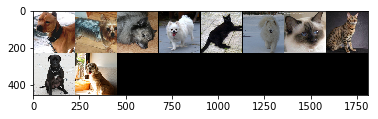

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# functions to show an image

def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels

print(' '.join('%5s' % labels[j] for j in range(4)))

定义神经网络

In [7]:
import torchvision.models as models
import torch.nn as nn

net = models.alexnet(num_classes=2)
# net = models.resnet18(num_classes=2)
net = net.cuda()

定义一个损失函数

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

Train the network

In [14]:
import time
t1 = time.time()
from torch.autograd import Variable
for epoch in range(10, 20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
#         inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training', time.time() - t1)

[11,   100] loss: 0.647
[11,   200] loss: 0.628
[11,   300] loss: 0.602
[12,   100] loss: 0.632
[12,   200] loss: 0.640
[12,   300] loss: 0.594
[13,   100] loss: 0.622
[13,   200] loss: 0.605
[13,   300] loss: 0.609
[14,   100] loss: 0.618
[14,   200] loss: 0.590
[14,   300] loss: 0.595
[15,   100] loss: 0.593
[15,   200] loss: 0.586
[15,   300] loss: 0.595
[16,   100] loss: 0.595
[16,   200] loss: 0.593
[16,   300] loss: 0.595
[17,   100] loss: 0.583
[17,   200] loss: 0.578
[17,   300] loss: 0.576
[18,   100] loss: 0.568
[18,   200] loss: 0.567
[18,   300] loss: 0.571
[19,   100] loss: 0.525
[19,   200] loss: 0.582
[19,   300] loss: 0.582
[20,   100] loss: 0.559
[20,   200] loss: 0.543
[20,   300] loss: 0.543
Finished Training 227.80919909477234


用训练出来的网络来做预测

In [10]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 3680 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 3680 test images: 67 %


GroundTruth:    Cat   Cat   Cat   Cat


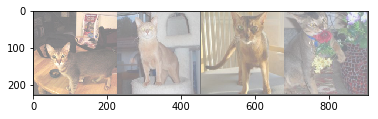

In [211]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# labels = labels.cuda()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [212]:
outputs = net(Variable(images.cuda()))
outputs.data


-0.8934  0.9164
-0.6358  0.6427
-0.9708  1.0174
-2.0869  2.1289
[torch.cuda.FloatTensor of size 4x2 (GPU 0)]

In [213]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    Dog   Dog   Dog   Dog


In [11]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
for data in testloader:
    images, labels = data
    labels = labels.cuda()
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(labels.size(0)):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   Cat :  0 %
Accuracy of   Dog : 100 %
